In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_tasks_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler
from train import config_load_special
import numpy as np
from utils.manual_solvers import w_sig_NGgenerator, w_sig_NGposterior, w_sig_ridge
import copy



%matplotlib inline
%load_ext autoreload
%autoreload 2


all_experiments = [
    "linear data",
    "linear + NN",
    "linear + NN + tree",
    "linear + Large NN + Deep tree"
]

path_dic = {
}


## load everything

model_dic = {}
ys_dic = {}
mus_dic = {}
sigs_dic = {}
exempt_dic = {}
predmu_dic = {}
predsigma_dic = {}

bayes_mus_dic = {}
bayes_sigs_dic = {}
ridge_mus_dic = {}
ridge_sigs_dic = {}
OLS_mus_dic = {}
OLS_sigs_dic = {}


for experiment in all_experiments:

    model_path = path_dic[experiment]

    model, _ = get_model_from_run(model_path)


    model_dic[experiment] = model

config = config_load_special(path_dic["linear data"])


n_dims = config.model.n_dims
batch_size = config.training.batch_size

data_sampler = get_data_sampler(config.training.data, n_dims)
xs = data_sampler.sample_xs(b_size=batch_size, n_points=config.training.curriculum.points.end)


sig_config = (20, 20)

mu0 = np.ones(n_dims)

## gamma(a, b), mean = a/b, variance = a/b^2
## when training, we let a/b=1 and b relatively large

a0, b0 = sig_config

new_ws, new_sigs = w_sig_NGgenerator(a0, b0, mu0, n_dims, batch_size)

config = copy.deepcopy(config)

config.training.task_kwargs["pool_dict"]["w"] = torch.Tensor(np.expand_dims(new_ws, axis=-1))
config.training.task_kwargs["pool_dict"]["sigma"] = torch.Tensor(new_sigs)
config.training.task_kwargs["pool_dict"]["exempt"] = np.zeros(batch_size)

task_sampler = get_task_sampler(
    config.training.task,
    n_dims,
    batch_size,
    **config.training.task_kwargs
)

task = task_sampler()

mus, ys, sigma, exemps = task.eval_with_mu_sigma_exempt(xs)




for experiment in all_experiments:

    with torch.no_grad():
        pred = model_dic[experiment](xs, ys)

        predmu_dic[experiment] = pred[:, :, 0]
        predsigma_dic[experiment] = pred[:, :, 1]

        posterior_mu = np.zeros(predmu_dic[experiment].shape)
        posterior_sigma = np.zeros(predmu_dic[experiment].shape)


        for selected_index in range(len(predmu_dic[experiment])):

            # estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
            #                                                 , mu0, MAP_sig=False, bias_adjust=True, pred_Ys= pred[selected_index, :, 0].cpu().numpy())

            estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
                                                            , mu0, MAP_sig=False, bias_adjust=False)


            real_estimated_ws = np.zeros(estimated_ws.shape)
            real_estimated_sigs = np.zeros(estimated_sigs.shape)

            real_estimated_ws[0] = mu0
            # real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2)
            real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2))




            # print("adjust_amount: ", np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2) \
            #       - np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2)))

            real_estimated_ws[1:] = estimated_ws[:-1]
            real_estimated_sigs[1:] = estimated_sigs[:-1]

            posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(real_estimated_ws, axis=-1))[:, 0, 0]
            posterior_sigma[selected_index, :] = real_estimated_sigs


        bayes_mus_dic[experiment] = posterior_mu
        bayes_sigs_dic[experiment] = posterior_sigma


# 6min

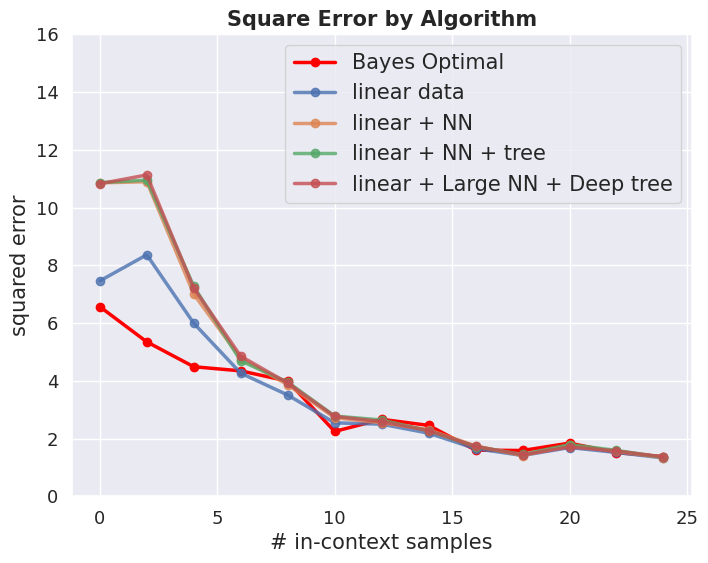

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def softplus(arr):
    return np.log(1+np.exp(arr))


L2_Bayes = {}
L2_model = {}

sample_exp = "linear data"

real_ys = ys.numpy()
bayes_mus = bayes_mus_dic[sample_exp]


L2_Bayes = np.square(real_ys - bayes_mus).mean(axis=0)

for experiment in all_experiments:

        real_ys = ys.numpy()
        preds = predmu_dic[experiment].numpy()

        L2_model[experiment] = np.square(real_ys - preds).mean(axis=0)




# Sample data
x_range = 25
x_base = np.arange(0, x_range)
dist_setting = "original"

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x_base[::2], savgol_filter(L2_Bayes[:x_range], \
                                   window_length=1, polyorder=0)[::2], '-o', label='Bayes Optimal', color="red", linewidth=2.5)


for experiment in all_experiments:
        ax.plot(x_base[::2], savgol_filter(L2_model[experiment][:x_range], window_length=5, polyorder=2)[::2], \
                'o-', label=experiment, linewidth=2.5, alpha=0.8)

# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('squared error', fontsize="15")
ax.set_ylim(0, 16) 
ax.set_title('Square Error by Algorithm', fontsize="15", fontweight='bold')

ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

# plt.savefig('figures/exp_1_L2_compare.eps', format='eps')
# plt.savefig('figures/exp_1_L2_compare.png', format='png')

# Show plot
plt.show()


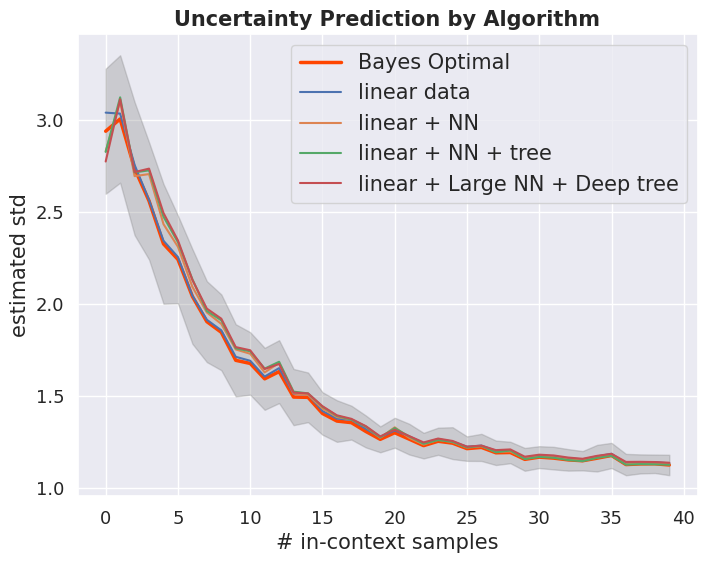

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


std_Bayes = {}
std_Ridge = {}
std_OLS = {}
std_model = {}
std_Bayes_fluc = {}
std_Ridge_fluc = {}
std_OLS_fluc = {}
std_model_fluc = {}

    
sample_experiment = "linear data"

bayes_mus = bayes_mus_dic[sample_experiment]
    
std_Bayes = bayes_sigs_dic[sample_experiment].mean(axis=0)
    
std_Bayes_fluc = bayes_sigs_dic[sample_experiment].std(axis=0)
    

for experiment in all_experiments:   

        std_model[experiment] = softplus(predsigma_dic[experiment].numpy()).mean(axis=0)
        std_model_fluc[experiment] = softplus(predsigma_dic[experiment].numpy()).std(axis=0)




# Sample data
x_range = 40
x_base = np.arange(0, x_range)
dist_setting = "original"

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x_base, savgol_filter(std_Bayes[:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes Optimal', color="orangered", linewidth = 2.5)
ax.fill_between(x_base, std_Bayes[:x_range] - std_Bayes_fluc[:x_range]/2, \
                std_Bayes[:x_range] + std_Bayes_fluc[:x_range]/2, \
                    color='grey', alpha=0.3)


for experiment in all_experiments:

        ax.plot(x_base, savgol_filter(std_model[experiment][:x_range], window_length=1, polyorder=0), \
                '-', label=experiment, ms=10)


# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('estimated std', fontsize="15")
# ax.set_ylim(0, 1) 
ax.set_title('Uncertainty Prediction by Algorithm', fontsize="15", fontweight='bold')

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

# plt.savefig('figures/exp_1_Std_pred.eps', format='eps')
# plt.savefig('figures/exp_1_Std_pred.png', format='png')

# Show plot
plt.show()
